In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.parameter import Parameter
import math
from torch.nn.modules.utils import _pair




from torchvision import datasets
from torchvision import transforms
from PIL import Image


from utils.model_utils import PatchLoader, NonLocalAggregation
from utils.martemev_utils import compute_psnr, get_freer_gpu, get_closest_diff

from time import time

# model[0].weight.grad

In [2]:
BATCH_SIZE = 64
NUM_WORKERS = 1

GPU_NUM = 1

K_CLOSEST = 8
HIDDEN_SIZE = 66
PATCH_SIZE = (33, 33)

MODEL_NAME = 'GraphCNN.wild_images'

In [3]:
def calculate_pad(shape1, shape2):
    """
    x -> dim=-2
    y -> dim=-1
    """
    return_pad = [0, 0, 0, 0]
    im_x, im_y = shape1
    pad_x, pad_y = shape2
    
    if (pad_x - (im_x%pad_x))%2 == 0:
        return_pad[2] = (pad_x - (im_x%pad_x))//2
        return_pad[3] = (pad_x - (im_x%pad_x))//2
    else:
        return_pad[2] = (pad_x - (im_x%pad_x))//2
        return_pad[3] = (pad_x - (im_x%pad_x))//2 + 1

    if (pad_y - (im_y%pad_y))%2 == 0:
        return_pad[0] = (pad_y - (im_y%pad_y))//2
        return_pad[1] = (pad_y - (im_y%pad_y))//2
    else:
        return_pad[0] = (pad_y - (im_y%pad_y))//2
        return_pad[1] = (pad_y - (im_y%pad_y))//2 + 1
    return return_pad

In [4]:
def split_image(image):
    p_x, p_y = PATCH_SIZE
    image = image.squeeze()
    image = F.pad(image, calculate_pad(image.shape, PATCH_SIZE), mode='constant', value=image.mean())
    splits = torch.split(torch.stack(torch.split(image, p_x)), p_y, dim=1)
    crops = torch.stack(splits, dim=1)        
    crops = crops.view(-1, 1, p_x, p_y)
    crops = torch.split(crops, BATCH_SIZE, dim=0)
    return crops, image.shape

In [5]:
def combine_image(crops, shape):
    shape_x, shape_y = shape
    answer = torch.cat([i for i in crops], dim=0)
    return answer.view(shape_x, shape_y)


In [6]:
def combine_image_model(crops, model, device, shape):
    shape_x, shape_y = shape
    answer = torch.cat([crop - model(crop.to(device)).cpu().data for crop in crops], dim=0)
    return answer.view(shape_x, shape_y)


In [7]:
class PlaneLoader(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        clean_path = '../Data/PolyU-Real-World-Noisy-Images-Dataset/OriginalImages/Mean/'
        noised_path = '../Data/PolyU-Real-World-Noisy-Images-Dataset/OriginalImages/Real/'
        clean_paths = os.listdir(clean_path)
        transfs = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
        self.clear_data = [transfs(Image.open(clean_path + filename)).squeeze() for filename in clean_paths]
        self.noised_data = [transfs(Image.open(noised_path + filename.replace('mean', 'Real'))).squeeze() for filename in clean_paths]
         
    def __len__(self):
        return len(self.noised_data)
    def __getitem__(self, index):
        return self.clear_data[index], self.noised_data[index]

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    PlaneLoader('../Data/train/clear/normalized_data.tensor',
                '../Data/train/noised/normalized_data.tensor'), 
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    PlaneLoader('../Data/val/clear/normalized_data.tensor',
                '../Data/val/noised/normalized_data.tensor'), 
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=True)

In [9]:
# gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(GPU_NUM))
# device = torch.device('cpu')

device

device(type='cuda', index=1)

In [10]:
def get_layers(n):
    for _ in range(n):
        yield [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU()]
        
def flatten(iterables):
    return (elem for iterable in iterables for elem in iterable)


In [11]:
def pairwise_dist(arr, k):
    """
    arr: torch.Tensor with shape batch x h*w x features
    """
    r_arr = torch.sum(arr * arr, dim=2, keepdim=True) # (B,N,1)
    mul = torch.matmul(arr, arr.permute(0,2,1))         # (B,M,N)
    dist = - (r_arr - 2 * mul + r_arr.permute(0,2,1))       # (B,M,N)
    return dist.topk(k=k, dim=-1)[1]

def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out


In [12]:
type(None) == type(None)

True

In [13]:
def get_closest_diff(arr, k, dists=None):
    """
    arr: torch.Tensor with shape batch x h * w x features
    """
    b, hw, f = arr.shape
    if type(dists) == type(None):
        dists = pairwise_dist(arr, k)
    selected = batched_index_select(arr, 1, dists.view(dists.shape[0], -1)).view(b, hw, k, f)
    diff = arr.unsqueeze(2) - selected
    return diff, dists


In [14]:
class NonLocalAggregation(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.k = k
        self.diff_fc = nn.Linear(input_channels, out_channels)
        self.w_self = nn.Linear(input_channels, out_channels, bias=True)
        
    def forward(self, x, dists=None):
        """
        x: torch.Tensor with shape batch x features x h x w
        """
        x = x.permute(0, 2, 3, 1)
        b, h, w, f = x.shape
        x = x.view(b, h*w, f)
        
        closest_graph, dists = get_closest_diff(x, self.k, dists)
        agg_weights = self.diff_fc(closest_graph) # look closer
        agg_self = self.w_self(x)
                
        x_new = torch.mean(agg_weights, dim=-2) + agg_self

        return x_new.view(b, h, w, x_new.shape[-1]).permute(0, 3, 1, 2), dists

In [15]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.NLA = NonLocalAggregation(k, input_channels, out_channels)
        
    def forward(self, x, dists=None):
        nla_res, _ = self.NLA(x, dists)
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       nla_res]), dim=0)


In [16]:
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x


In [17]:
class ResBlock(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.gc = GraphConv(k, input_channels, out_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activ = nn.LeakyReLU(0.05)
        
    def forward(self, x, dists=None):
        x = self.gc(x, dists)
        x = self.activ(self.bn(x))
        return x, dists
    
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.res1 = ResBlock(k, input_channels, input_channels)
        self.res2 = ResBlock(k, input_channels, input_channels)
        self.res3 = ResBlock(k, input_channels, out_channels)
        
        
    def forward(self, x):
        x, dists = self.res1(x)
        x, dists = self.res2(x, dists)
        x, dists = self.res3(x, dists)
        return x


In [18]:
class GCNN(nn.Module):
    def __init__(self, k, input_channels=1, hidden_channels=22):
        super().__init__()
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels*3)
        self.residual_2 = Residual(k, hidden_channels*3, hidden_channels*3)
        
        self.GC = GraphConv(k, hidden_channels*3, input_channels)
        
    def forward(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image) + processed_image
        residual_2 = self.residual_2(residual_1) + residual_1
        return self.GC(residual_2)


In [27]:
model = GCNN(K_CLOSEST, 1, 22).to(device)

optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: 0.97**x)

In [20]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [20]:
val_images_clear = val_dataloader.dataset.clear_data
val_images_noised = val_dataloader.dataset.noised_data

In [ ]:
for epoch in tqdm.tqdm_notebook(range(100)):
    model.train()
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        image_mean = image.mean()
        for clean_crop_batch, noisy_crop_batch in tqdm.tqdm_notebook(zip(split_image(image)[0], split_image(noise_image)[0]), leave=False):
            optim.zero_grad()
            clean_crop_batch, noisy_crop_batch = clean_crop_batch.to(device), \
                                                    noisy_crop_batch.to(device)
            start_time = time()
            denoised_diff = model(noisy_crop_batch)
            end_time = time() - start_time
            writer.add_scalar('train/iteration_time', end_time)
            added_noise = noisy_crop_batch - clean_crop_batch
            max_signals = torch.max(clean_crop_batch.view(image.shape[0], -1), dim=1)[0] + image_mean
            weighted_mse = torch.mean(max_signals * torch.mean(((denoised_diff - added_noise)**2).view(denoised_diff.shape[0], -1), dim=(1)))
            loss = weighted_mse
            writer.add_scalar('train/weighted_mse_loss', loss.item())
            writer.add_scalar('train/plain_mse_loss', nn.MSELoss()(denoised_diff, added_noise).item())
            loss.backward()
            
            layer_1_grad = np.mean([model.preprocessing_blocks[b].conv.weight.grad.data.norm(2).item() for b in range(3)])
            
            writer.add_scalar('grad/layer_1', layer_1_grad)
            writer.add_scalar('grad/layer_53', model.GC.conv2.weight.grad.data.norm(2).item())
            writer.add_scalar('grad/layer_38', model.residual_2.res1.gc.conv2.weight.grad.data.norm(2).item())
            writer.add_scalar('grad/layer_11', model.residual_1.res1.gc.conv2.weight.grad.data.norm(2).item())
            
            optim.step()
            writer.add_scalar('train/psnr', compute_psnr(clean_crop_batch, noisy_crop_batch - denoised_diff))
    scheduler.step()
    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image_mean = image.mean()
        for clean_crop_batch, noisy_crop_batch in tqdm.tqdm_notebook(zip(split_image(image)[0], split_image(noise_image)[0]), leave=False):
            clean_crop_batch, noisy_crop_batch = clean_crop_batch.to(device), \
                                                    noisy_crop_batch.to(device)
            denoised_diff = model(noisy_crop_batch)
            added_noise = noisy_crop_batch - clean_crop_batch
            max_signals = torch.max(clean_crop_batch.view(image.shape[0], -1), dim=1)[0] + image_mean
            weighted_mse = torch.mean(max_signals * torch.mean(((denoised_diff - added_noise)**2).view(denoised_diff.shape[0], -1), dim=(1)))
            loss = weighted_mse
            losses.append(loss.item())
            psnrs.append(compute_psnr(clean_crop_batch, noisy_crop_batch - denoised_diff))
    writer.add_scalar('val/psnr', np.mean(psnrs), epoch)
    writer.add_scalar('val/combined_loss', np.mean(losses), epoch)
    img_indexes = torch.randint(high=len(noisy_crop_batch), size=(10,))
    dummy_img = torch.cat([clean_crop_batch[img_indexes],
                           noisy_crop_batch[img_indexes],
                           (noisy_crop_batch - denoised_diff)[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, epoch)

    img_index = torch.randint(high=len(val_images_clear), size=(1,))
    clear_image = val_images_clear[img_index]
    noised_image = val_images_noised[img_index]
    start_time = time()
    noised_image_chunks, image_shape = split_image(noised_image)
    denoised_image = combine_image_model(noised_image_chunks, model, device, image_shape)
    end_time = time() - start_time
    writer.add_scalar('val/full_image_time', end_time, epoch)
    writer.add_image('val/clear_image', clear_image, epoch, dataformats='HW')
    writer.add_image('val/noised_image', noised_image, epoch, dataformats='HW')
    writer.add_image('val/denoised_image', denoised_image, epoch, dataformats='HW')            


In [ ]:
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))


In [28]:
model.load_state_dict(torch.load('SavedModels/{}.state_dict'.format(MODEL_NAME)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
img_index = torch.randint(high=len(val_images_clear), size=(1,))
clear_image = val_images_clear[img_index]
noised_image = val_images_noised[img_index]
start_time = time()
noised_image_chunks, image_shape = split_image(noised_image)
denoised_image = combine_image_model(noised_image_chunks, model, device, image_shape)
end_time = time() - start_time

In [43]:
img_index

tensor([12])

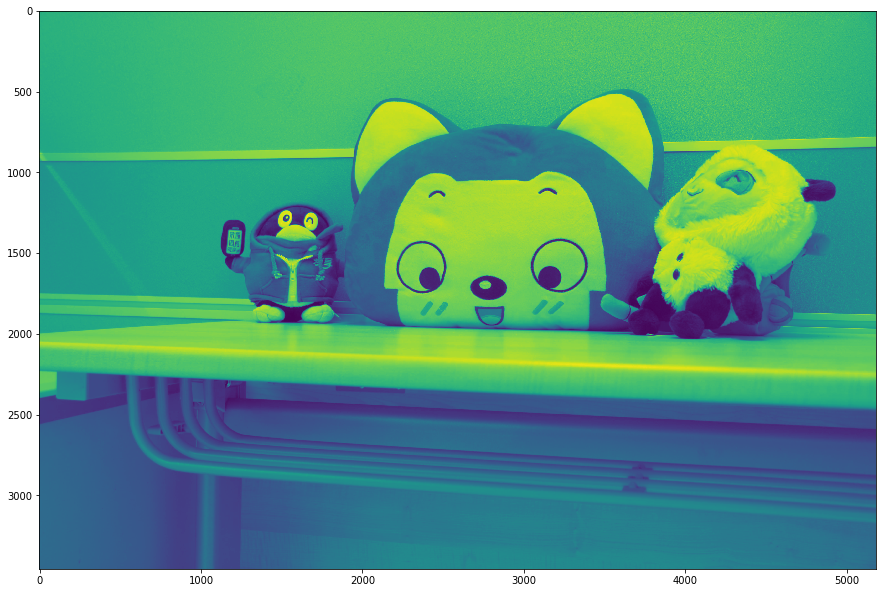

In [31]:
plt.figure(figsize=(15, 15))

plt.imshow(clear_image)
plt.show()

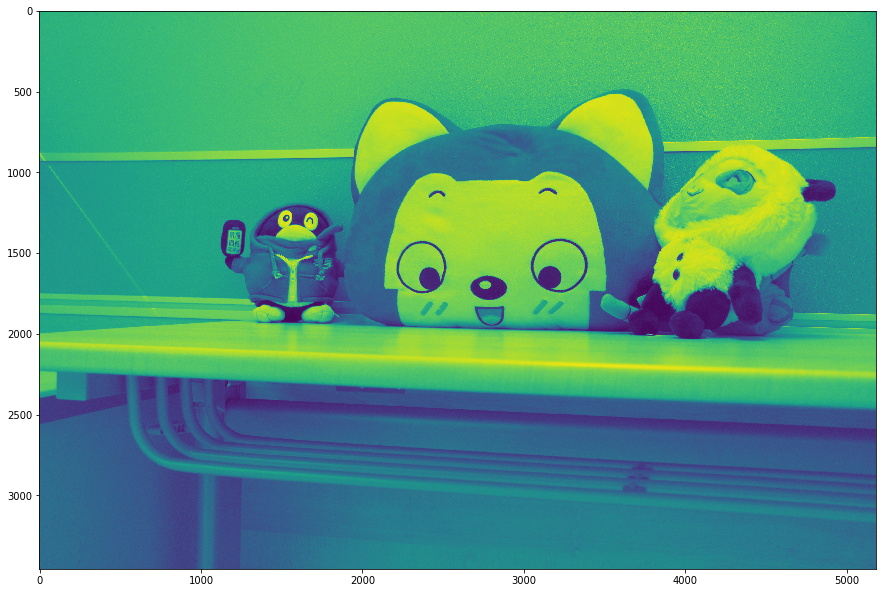

In [32]:
plt.figure(figsize=(15, 15))

plt.imshow(noised_image)
plt.show()

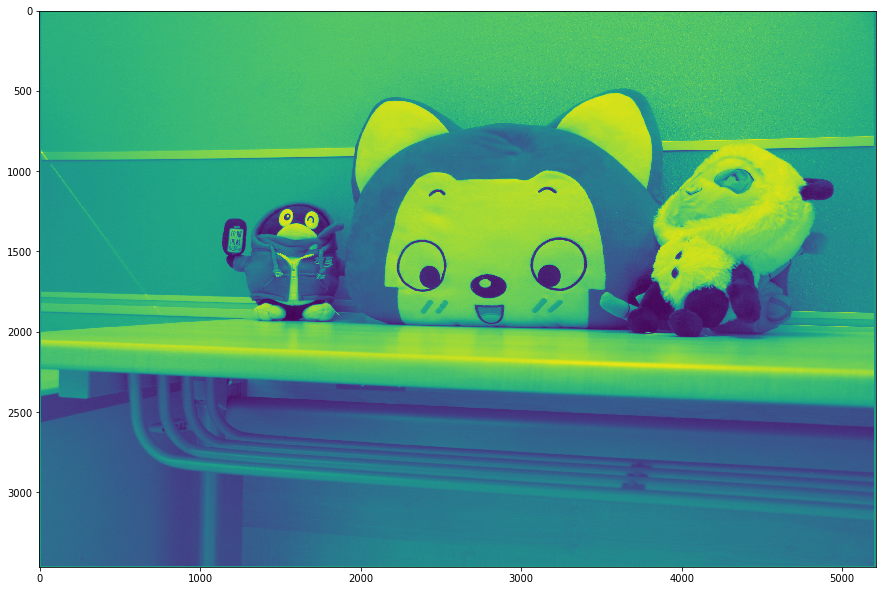

In [33]:
plt.figure(figsize=(15, 15))

plt.imshow(denoised_image)
plt.show()

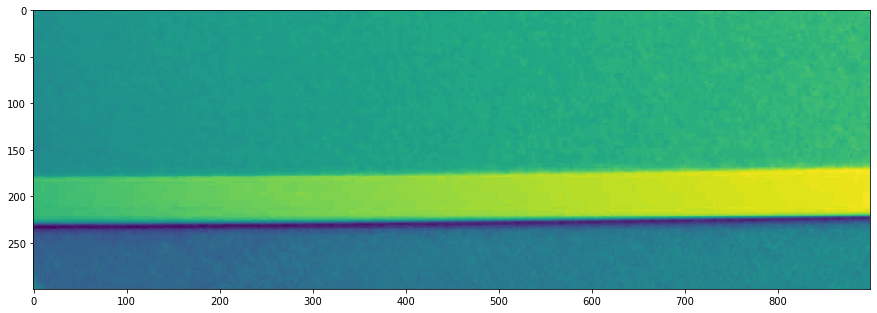

In [40]:
plt.figure(figsize=(15, 15))

plt.imshow(clear_image[700:1000, 100:1000])
plt.show()

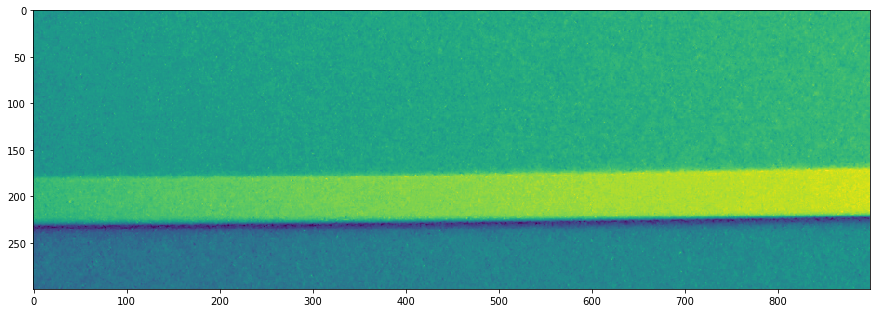

In [41]:
plt.figure(figsize=(15, 15))

plt.imshow(noised_image[700:1000, 100:1000])
plt.show()

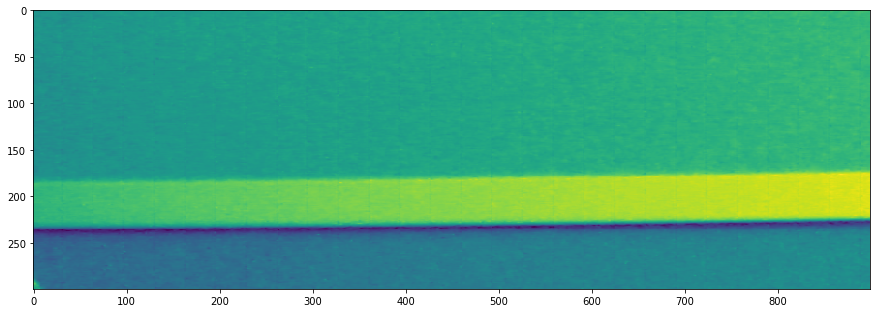

In [42]:
plt.figure(figsize=(15, 15))

plt.imshow(denoised_image[700:1000, 100:1000])
plt.show()